# T81-558: Applications of Deep Neural Networks
**Class 8: Convolutional Neural Networks.**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), School of Engineering and Applied Science, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Common Functions

In [1]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df,name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name,x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the origional column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df,name,target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x)==str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name,tv)
        df[name2] = l
    
# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df,name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Encode a numeric column as zscores
def encode_numeric_zscore(df,name,mean=None,sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name]-mean)/sd

# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)

# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)

# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df,target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)

    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        return df.as_matrix(result).astype(np.float32),df.as_matrix([target]).astype(np.int32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32),df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# Regression chart, we will see more of this chart in the next class.
def chart_regression(pred,y):
    t = pd.DataFrame({'pred' : pred, 'y' : y_test.flatten()})
    t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()
    
# Get a new directory to hold checkpoints from a neural network.  This allows the neural network to be
# loaded later.  If the erase param is set to true, the contents of the directory will be cleared.
def get_model_dir(name,erase):
    base_path = os.path.join(".","dnn")
    model_dir = os.path.join(base_path,name)
    os.makedirs(model_dir,exist_ok=True)
    if erase and len(model_dir)>4 and os.path.isdir(model_dir):
        shutil.rmtree(model_dir,ignore_errors=True) # be careful, this deletes everything below the specified path
    return model_dir

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name]-df[name].mean())>=(sd*df[name].std()))]
    df.drop(drop_rows,axis=0,inplace=True)
    
# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low =-1, normalized_high =1, 
                         data_low=None, data_high=None):
    
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])
    
    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
                * (normalized_high - normalized_low) + normalized_low

This class will focus on computer vision.  There are some important differences and similarities with previous neural networks.

* We will usually use classification, though regression is still an option.
* The input to the neural network is now 3D (height, width, color)
* Data are not transformed, no zscores or dummy variables.
* Processing time is much longer.
* We now have different layer times: dense layers (just like before), convolution layers and max pooling layers.
* Data will no longer arrive as CSV files. TensorFlow provides some utilities for going directly from image to the input fo a neural network.


# Computer Vision Data Sets

There are many data sets for computer vision.  Two of the most popular are the MNIST digits data set and the CIFAR image data sets.

## MNIST Digits Data Set

The [MNIST Digits Data Set](http://yann.lecun.com/exdb/mnist/) is very popular in the neural network research community.  A sample of it can be seen here:

![MNIST Data Set](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_8_mnist.png "MNIST Data Set")

This data set was generated from scanned forms.

![Exam](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_8_exam.png "Exam")


## CIFAR Data Set

The [CIFAR-10 and CIFAR-100](https://www.cs.toronto.edu/~kriz/cifar.html) datasets are also frequently used by the neural network research community.

![cifar-10](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_8_cifar.png "cifar-10")

The CIFAR-10 data set contains low-rez images that are divided into 10 classes.  The CIFAR-100 data set contains 100 classes in a hierarchy. 

# Other Resources

* [Imagenet:Large Scale Visual Recognition Challenge 2014](http://image-net.org/challenges/LSVRC/2014/index)
* [Andrej Karpathy](http://cs.stanford.edu/people/karpathy/) - PhD student/instructor at Stanford.
    * [CS231n Convolutional Neural Networks for Visual Recognition](http://cs231n.stanford.edu/) - Stanford course on computer vision/CNN's.
        * [CS231n - GitHub](http://cs231n.github.io/)
    * [ConvNetJS](http://cs.stanford.edu/people/karpathy/convnetjs/) - Javascript library for deep learning.
 

# Convolutional Neural Networks (CNNs)

The convolutional neural network (CNN) is a neural network technology that has profoundly impacted the area of computer vision (CV). Fukushima (1980) introduced the original concept of a convolutional neural network, and LeCun, Bottou, Bengio & Haffner (1998) greatly improved this work. From this research, Yan LeCun introduced the famous LeNet-5 neural network architecture. This class follows the LeNet-5 style of convolutional neural network.

**A LeNET-5 Network (LeCun, 1998)**
![LENET5](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_8_lenet5.png "LENET5")

So far we have only seen one layer type (dense layers).  By the end of this course we will have seen:

* **Dense Layers** - Fully connected layers.  (introduced previously)
* **Convolution Layers** - Used to scan across images. (introduced this class)
* **Max Pooling Layers** - Used to downsample images. (introduced this class)
* **Dropout Layer** - Used to add regularization. (introduced next class)

## Convolution Layers

The first layer that we will examine is the convolutional layer. We will begin by looking at the hyper-parameters that you must specify for a convolutional layer in most neural network frameworks that support the CNN:

* Number of filters
* Filter Size
* Stride
* Padding
* Activation Function/Non-Linearity

The primary purpose for a convolutional layer is to detect features such as edges, lines, blobs of color, and other visual elements. The filters can detect these features. The more filters that we give to a convolutional layer, the more features it can detect.

A filter is a square-shaped object that scans over the image. A grid can represent the individual pixels of a grid. You can think of the convolutional layer as a smaller grid that sweeps left to right over each row of the image. There is also a hyper parameter that specifies both the width and height of the square-shaped filter. Figure 10.1 shows this configuration in which you see the six convolutional filters sweeping over the image grid:

A convolutional layer has weights between it and the previous layer or image grid. Each pixel on each convolutional layer is a weight. Therefore, the number of weights between a convolutional layer and its predecessor layer or image field is the following:

```
[FilterSize] * [FilterSize] * [# of Filters]
```

For example, if the filter size were 5 (5x4) for 10 filters, there would be 250 weights.

You need to understand how the convolutional filters sweep across the previous layer’s output or image grid. Figure 10.2 illustrates the sweep:

![CNN](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_8_cnn_grid.png "CNN")

The above figure shows a convolutional filter with a size of 4 and a padding size of 1. The padding size is responsible for the boarder of zeros in the area that the filter sweeps. Even though the image is actually 8x7, the extra padding provides a virtual image size of 9x8 for the filter to sweep across. The stride specifies the number of positions at which the convolutional filters will stop. The convolutional filters move to the right, advancing by the number of cells specified in the stride. Once the far right is reached, the convolutional filter moves back to the far left, then it moves down by the stride amount and
continues to the right again.

Some constraints exist in relation to the size of the stride. Obviously, the stride cannot be 0. The convolutional filter would never move if the stride were set to 0. Furthermore, neither the stride, nor the convolutional filter size can be larger than the previous grid. There are additional constraints on the stride (s), padding (p) and the filter width (f) for an image of width (w). Specifically, the convolutional filter must be able to start at the far left or top boarder, move a certain number of strides, and land on the far right or bottom boarder. The following equation shows the number of steps a convolutional operator
must take to cross the image:

$ steps = \frac{w - f + 2p}{s+1} $

The number of steps must be an integer. In other words, it cannot have decimal places. The purpose of the padding (p) is to be adjusted to make this equation become an integer value.

## Max Pooling Layers

Max-pool layers downsample a 3D box to a new one with smaller dimensions. Typically, you can always place a max-pool layer immediately following convolutional layer. The LENET shows the max-pool layer immediately after layers C1 and C3. These max-pool layers progressively decrease the size of the dimensions of the 3D boxes passing through them. This technique can avoid overfitting (Krizhevsky, Sutskever & Hinton, 2012).

A pooling layer has the following hyper-parameters:

* Spatial Extent (f )
* Stride (s)

Unlike convolutional layers, max-pool layers do not use padding. Additionally, max-pool layers have no weights, so training does not affect them. These layers simply downsample their 3D box input. The 3D box output by a max-pool layer will have a width equal to this equation:

$ w_2 = \frac{w_1 - f}{s + 1} $

The height of the 3D box produced by the max-pool layer is calculated similarly with this equation:

$ h_2 = \frac{h_1 - f}{s + 1} $

The depth of the 3D box produced by the max-pool layer is equal to the depth the 3D box received as input. The most common setting for the hyper-parameters of a max-pool layer are f =2 and s=2. The spatial extent (f) specifies that boxes of 2x2 will be scaled down to single pixels. Of these four pixels, the pixel with the maximum value will represent the 2x2 pixel in the new grid. Because squares of size 4 are replaced with size 1, 75% of the pixel information is lost. The following figure shows this transformation as a 6x6 grid becomes a 3x3:

![MaxPool](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_8_conv_maxpool.png "MaxPool")

Of course, the above diagram shows each pixel as a single number. A grayscale image would have this characteristic. For an RGB image, we usually take the average of the three numbers to determine which pixel has the maximum value.

[More information on CNN's](http://cs231n.github.io/convolutional-networks/)

# TensorFlow with CNNs

The following sections describe how to use TensorFlow/SKFlow with CNNs.



# Access to Data Sets

TensorFlow provides built in access classes for MNIST.  It is important to note that MNIST data arrives already separated into three sets:

* **train** - Neural network will be trained with this.
* **test** - Used for early stopping.
* **validation** - Used to evaluate the final network.

In [2]:
"""Functions for downloading and reading MNIST data."""
import gzip
import os
import tempfile

import numpy
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets

# Loading MNIST data
mnist = read_data_sets('MNIST_data')

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


# Display the Digits 

The following code shows what the MNIST files contain.

In [15]:
# Display as text
from IPython.display import display
import pandas as pd

print("Shape for dataset: {}".format(mnist.train.images.shape))
print("Labels: {}".format(mnist.train.labels))

# Single MNIST digit
single = mnist.train.images[0]
print("Shape for single: {}".format(single.shape))

display(pd.DataFrame(single.reshape(28,28)))

Shape for dataset: (55000, 784)
Labels: [7 3 4 ..., 5 6 8]
Shape for single: (784,)


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.000000,0.352941,0.541176,0.921569,0.921569,0.921569,0.921569,0.921569,...,0.082353,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.549020,0.984314,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,...,0.741176,0.090196,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


Image (#100): Which is digit '7'


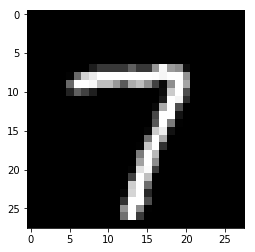

In [5]:
# Display as image

import matplotlib.pyplot as plt
import numpy as np

digit = 100 # Change to choose new digit

a = mnist.train.images[digit].reshape(28,28)
plt.imshow(a, cmap='gray', interpolation='nearest')
print("Image (#{}): Which is digit '{}'".format(digit,mnist.train.labels[digit]))
plt.show()

# Define CNN

In [5]:
import tensorflow.contrib.learn as learn
from sklearn import datasets, metrics
import numpy as np

layers = tf.contrib.layers
learn = tf.contrib.learn

def max_pool_2x2(tensor_in):
  return tf.nn.max_pool(
      tensor_in, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


def conv_model(feature, target, mode):
  """2-layer convolution model."""
  # Convert the target to a one-hot tensor of shape (batch_size, 10) and
  # with a on-value of 1 for each one-hot vector of length 10.
  target = tf.one_hot(tf.cast(target, tf.int32), 10, 1, 0)

  # Reshape feature to 4d tensor with 2nd and 3rd dimensions being
  # image width and height final dimension being the number of color channels.
  feature = tf.reshape(feature, [-1, 28, 28, 1])

  # First conv layer will compute 32 features for each 5x5 patch
  with tf.variable_scope('conv_layer1'):
    h_conv1 = layers.convolution(
        feature, 32, kernel_size=[5, 5], activation_fn=tf.nn.relu)
    h_pool1 = max_pool_2x2(h_conv1)

  # Second conv layer will compute 64 features for each 5x5 patch.
  with tf.variable_scope('conv_layer2'):
    h_conv2 = layers.convolution(
        h_pool1, 64, kernel_size=[5, 5], activation_fn=tf.nn.relu)
    h_pool2 = max_pool_2x2(h_conv2)
    # reshape tensor into a batch of vectors
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 64])

  # Densely connected layer with 1024 neurons.
  h_fc1 = layers.dropout(
      layers.fully_connected(
          h_pool2_flat, 1024, activation_fn=tf.nn.relu),
      keep_prob=0.5,
      is_training=mode == tf.contrib.learn.ModeKeys.TRAIN)

  # Compute logits (1 per class) and compute loss.
  logits = layers.fully_connected(h_fc1, 10, activation_fn=None)
  loss = tf.contrib.losses.softmax_cross_entropy(logits, target)

  # Create a tensor for training op.
  train_op = layers.optimize_loss(
      loss,
      tf.contrib.framework.get_global_step(),
      optimizer='SGD',
      learning_rate=0.001)

  return tf.argmax(logits, 1), loss, train_op


## Training/Fitting CNN

The following code will train the CNN for 20,000 steps.  This can take awhile, you might want to scale the step count back. GPU training can help.  My results:

* CPU Training Time: Elapsed time: 1:50:13.10
* GPU Training Time: Elapsed time: 0:13:43.06

In [6]:
import tensorflow as tf
import tensorflow.contrib.learn as learn
import time

# Set the desired TensorFlow output level for this example
tf.logging.set_verbosity(tf.logging.INFO)

# Get/clear a directory to store the neural network to
model_dir = get_model_dir('mnist-cnn',True)

start_time = time.time()

classifier = learn.Estimator(model_fn=conv_model,model_dir=model_dir)
classifier.fit(mnist.train.images,
                 mnist.train.labels,
                 batch_size=100,
                 steps=20000)

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_evaluation_master': '', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000020D8EE84E48>, 'keep_checkpoint_max': 5, '_environment': 'local', '_num_ps_replicas': 0, '_master': '', 'keep_checkpoint_every_n_hours': 10000, 'save_summary_steps': 100, 'tf_random_seed': None, 'save_checkpoints_steps': None, 'save_checkpoints_secs': 600, '_task_type': None, '_task_id': 0}
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and b

## Evaluate Accuracy

Note, if you are using a GPU you might get the **ResourceExhaustedError**.  This occurs because the GPU might not have enough ram to predict the entire data set at once.  

In [11]:
# Predict using either GPU or CPU, send the entire dataset.  This might not work on the GPU.
# Set the desired TensorFlow output level for this example
tf.logging.set_verbosity(tf.logging.ERROR)

score = metrics.accuracy_score(mnist.test.labels,
                                 list(classifier.predict(mnist.test.images)))
print('Accuracy: {0:f}'.format(score))

Accuracy: 0.989899


In [10]:
# For GPU just grab the first 100 images
small_x = mnist.test.images[1:100]
small_y = mnist.test.labels[1:100]

score = metrics.accuracy_score(small_y, list(classifier.predict(small_x)))
print('Accuracy: {0:f}'.format(score))

Accuracy: 0.989899


# Latest Advances in CNN's

He, K., Zhang, X., Ren, S., & Sun, J. (2016). [Deep residual learning for image recognition](https://arxiv.org/abs/1512.03385). In *Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition* (pp. 770-778).

* [Caffee ResNet GitHub](https://github.com/KaimingHe/deep-residual-networks)
* [ResNet in TensorFlow](https://github.com/tensorflow/models/blob/master/resnet/resnet_model.py)
